In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#font size 18,pdf font type 42
plt.rcParams.update({'font.size': 18, 'pdf.fonttype': 42})
import networkx as nx

from Bio import Phylo

In [2]:
def get_network(path):
    tree = Phylo.read(path,'newick')
    tree.rooted=True
    net = Phylo.to_networkx(tree)
    net = nx.relabel.convert_node_labels_to_integers(net,label_attribute='MEDICC2')
    return net

In [3]:
def get_leaf_branch_lengths(net,mrca_node):

    dfs_nodes = list(nx.dfs_edges(net, source=mrca_node))
    cumulative_branch_length_store = {mrca_node:0}

    for source_node,sink_node in dfs_nodes:
        source_cumulative_branch_length = cumulative_branch_length_store[source_node]
        sink_branch_length = net.nodes[sink_node]['MEDICC2'].branch_length
        
        cumulative_branch_length_store[sink_node] = source_cumulative_branch_length+sink_branch_length
    sink_node_branch_lengths = [cumulative_branch_length_store[node] for node in net.nodes() if node in cumulative_branch_length_store and net.out_degree(node)==0]
    return np.array(sink_node_branch_lengths)

In [4]:
def get_pseudo_mrca(net,target=0.9):
    n_descendants = []
    node_store = []
    for node in net.nodes():
        n_descendants.append(len(nx.descendants(net,node)))
        node_store.append(node)
    n_descendants = np.array(n_descendants)/len(net.nodes())
    target_index = np.argmin(np.abs(n_descendants-target))
    return node_store[target_index],n_descendants[target_index]
    

In [5]:
branch_length_store = {}
for region in ['R2','R3','R4']:
    path = f'../in_data/usarc_meddicc/usarc_nodoublet_2.5_{region}_final_tree.new'
    net = get_network(path)
    mrca_node,descendant_proportion = get_pseudo_mrca(net)
    sink_node_branch_lengths = get_leaf_branch_lengths(net,mrca_node)
    branch_length_store[region] = sink_node_branch_lengths

R2 R3 MannwhitneyuResult(statistic=286.0, pvalue=0.002494519663401528)
R2 R4 MannwhitneyuResult(statistic=469.5, pvalue=4.8274772165048954e-14)
R3 R4 MannwhitneyuResult(statistic=1777.0, pvalue=0.005020644624784021)


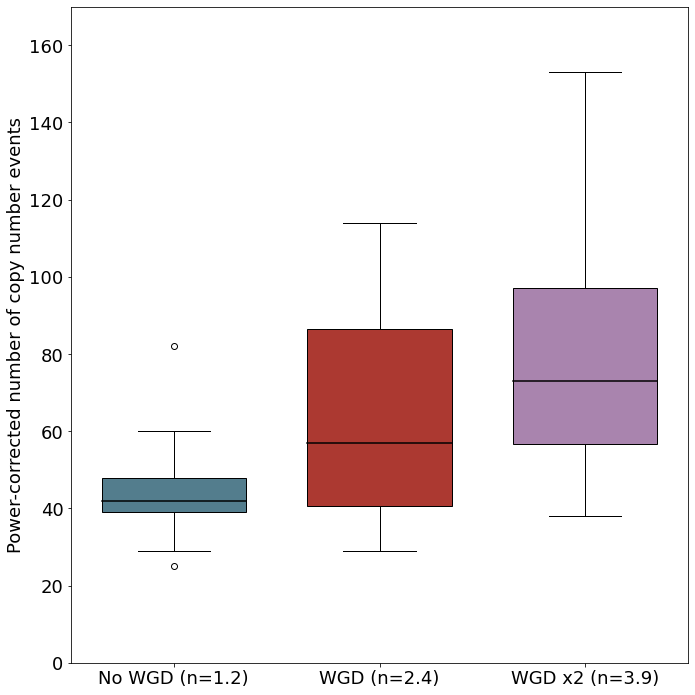

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
labels = ['No WGD (n=1.2)','WGD (n=2.4)','WGD x2 (n=3.9)']
patches = ax.boxplot([branch_length_store['R2'],branch_length_store['R3'],branch_length_store['R4']],labels=labels,patch_artist=True,widths=0.7)
ax.set_ylabel('Power-corrected number of copy number events')
colors = ['#537D8D','#AC3931','#A984AE']
for patch,color in zip(patches['boxes'],colors):
    patch.set_facecolor(color)
#set median line color
for median in patches['medians']:
    median.set_color('black')
    median.set_linewidth(1.5)
#do pairwise mann whitney u test
from scipy.stats import mannwhitneyu
for region1,region2 in [('R2','R3'),('R2','R4'),('R3','R4')]:
    print(region1,region2,mannwhitneyu(branch_length_store[region1],branch_length_store[region2]))
ax.set_ylim(0,170)
plt.tight_layout()
plt.savefig('../plots/usarc_analysis/usarc_medic_mrca_distances.pdf')